# Frame-level Video Anomaly Detection on UCSD Pedestarian Dataset

This notebook outlines a recently proposed state-of-the-art deep learning method for frame-level video anomaly detection, as presented in CVPR 2023. We evaluate this method using the benchmark UCSD pedestrian dataset, which has been widely employed in numerous prior studies.

The notebook is structured as follows:

1. [Environment Setup and Imports](#section2)


2. [UCSD Pedestarian](#section1)
    
    2.1. [Load Data Configuration](#section2.2)

    2.2. [Train Data Loading](#section2.2)

    2.3. [Test Data Loading](#section2.3)
    

3. [Unsupervised Video Anomaly Detection Methods]()
    

4. [Diversity Measurable Anomaly Detection Model](#section3)

    4.1. [Model Architecture](#section3.1)

    4.2. [Load Model Configuration](#section2.2)

    4.3. [Model Instantiation](#section3.2)

    4.4. [Model Training/Loading](#section3.2)

    4.5. [Model Evaluation](#section3.3)
    

5. [Inference and Visualization](#section4)


6. [Weakly Supervised Video Anomaly Detection Methods]()

<a id='section1'></a>
## 1. Environment Setup and Imports


In this initial step, we commence by importing the required packages for our experiments. Furthermore, we set up the paths for loading saved models, test and train data path , which are defined as **LOAD_PATH**, **TRAIN_DATA_PATH** and **TEST_DATA_PATH**, respectively.

In [1]:
import yaml
from sklearn.metrics import roc_auc_score
from IPython.display import HTML

from Dataset.UCSD_dataset import load_test_data,load_train_data
from DMAD.run import DMAD

LOAD_PATH = '/ssd003/projects/aieng/public/anomaly_detection_models/UCSD/'
TRAIN_DATA_PATH = '/ssd003/projects/aieng/public/anomaly_detection_datasets/UCSD_Anomaly_Dataset/UCSDped2/Train'
TEST_DATA_PATH = '/ssd003/projects/aieng/public/anomaly_detection_datasets/UCSD_Anomaly_Dataset/UCSDped2/Test'

<a id='section1'></a>
## 2. UCSD Pedestrian Dataset

The UCSD Anomaly Detection dataset is created by utilizing a fixed camera placed at an elevated position for observation, providing an overview of pedestrian walkways. The dataset was collected in a spacious walkway where pedestrians moved parallel to the camera plane. Across these walkways, the density of the crowd varied from sparse to becoming highly congested.

In the **normal scenario**, the recorded video portrayed only pedestrians. **Abnormal scenarios** accured due to: 

1. the presence of non-pedestrian entities moving within the walkways, e.g., cyclists, skateboarders, small carts, and individuals traversing the walkway.
2. atypical patterns in pedestrian movement.

Also, it is important to emphasize that all these anomalies occurred naturally and were not staged for the purpose of creating the dataset.

The dataset comprises **16 training video samples** and **12 testing video samples**, each containing **approximately 200 frames**. The recorded video footage from each scene was segmented into various clips. Here are a few exemplars from the dataset:

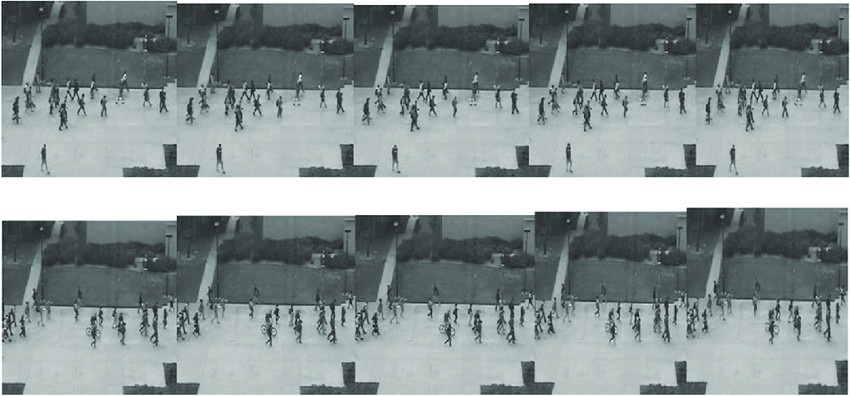

The upper row contains normal frames, and the lower row contains abnormal frames.

<a id='section1'></a>
### 2.1. Load Data Configuration


For conducting training, we additionally supply a `data_config` file that encompasses the parameters for data loading. The `data_config` file is situated in the `config_path`. We load this file and display its contents to observe the parameters as outlined below:

In [2]:
config_path = 'Dataset/data_config.yaml'
with open(config_path) as cf_file:
    data_config = yaml.safe_load(cf_file.read())['data_config']

In [3]:
data_config

{'h': 256, 'w': 256, 'c': 3, 'time_step': 4}

This configuration encompasses three parameters pertaining to the input image: height, width, and channels, denoted as `h, w, c`. Because video data encapsulates temporal information, we enrich each frame with its preceding history by integrating four previous frames, indicated as `time_step`. This temporal context empowers the model to encapsulate temporal patterns in conjunction with spatial scenes, consequently bolstering its proficiency in anomaly detection.

<a id='section1'></a>
### 2.2. Train Data Loading

We can load all these frames using the `load_train_data` function. This function receives the path to the training data as `TRAIN_DATA_PATH`, along with the corresponding `data_config` file, and it returns a PyTorch dataset. This dataset encompasses a total of `2486 normal frames`.

In [4]:
train_dataset = load_train_data(TRAIN_DATA_PATH, data_config)

### 2.3. Test Data Loading

The test dataset comprises videos featuring both normal and abnormal frames. To load the test data, we can employ the `load_test_data` function. This function takes the `TEST_DATA_PATH` (the path to the test data) and the `data_config` as inputs and yields a list of test PyTorch datasets along with their corresponding frame-level ground truth labels. These ground truth labels are essential for evaluating the performance of our model.

Moreover, by specifying the `inference_video_name`, we can identify a particular video for inference purposes. If the video name is not specified, the function will load all the videos within the test data.

In [5]:
test_datasets, test_ground_truth = load_test_data(TEST_DATA_PATH, data_config, inference_video_name = None)

<a id='section1'></a>
## 3. Unsupervised Video Anomaly Detection Methods

In contrast to classical action recognition tasks, collecting relevant videos for anomaly detection poses a challenge due to the sensitivity and scarcity of anomalous events. Consequently, the mainstream approach for frame-level anomaly detection is unsupervised methods where the training data comprises solely normal samples and the test data contains both normal and abnormal samples. 

The table below shows comparision of different **state-of-the-art unsupervised frame-level video anomaly detection methods** on **UCSD Pedestrian dataset**. In this notebook, we will delve into the **Diversity Measurable Anomaly Detection (DMAD)** method presented in CVPR 2023, which outperforms all other methods in terms of AUC-ROC without utilizing any external estimatore.

![results.png](images/results.png)

The list of additional unsupervised methods and their repositary is presented in below, as an alternative apprach for DMAD over UCSD pedestrian dataset:

- A Hybrid Video Anomaly Detection Framework via Memory-Augmented Flow Reconstruction and Flow-Guided Frame Prediction (HF2VAD): https://github.com/LiUzHiAn/hf2vad
- Learning Memory-guided Normality for Anomaly Detection (MNAD): https://github.com/cvlab-yonsei/MNAD
- Learning Normal Dynamics in Videos with Meta Prototype Network (MPN): https://github.com/ktr-hubrt/MPN/
- Memory-augmented Deep Autoencoder for Unsupervised Anomaly Detection (MemAE): https://github.com/donggong1/memae-anomaly-detection

## 4. Diversity Measurable Anomaly Detection Model

**Reconstruction-based** approaches are one of the common **unsupervised frame-level video anomaly detection methods**. These methods are designed to train an **auto-encoder based model** to recostruct normal training samples and detect anomalies in test set by measuring their reconstruction error. However they are limited in generalizing reconstruction ability to unusual cases as it often struggles to accurately recreate a wide variety of normal patterns. 


![diversity.png](images/diversity.png)

### 4.1. Model Architecture

- **DMAD** is a reconstruction based method which aims to find a better balance by improving the diversity in reconstructions while also avoiding incorrect generalizations to anomalies. To do so it employs two novel modules:

    - **Information Compression Module (ICM)**, which is integrated to the auto-encoder to separate deformation from prototypical normal embedding, resulting in more dependable anomaly scores.
    - **Pyramid Deformation Module (PDM)**, which not only models different normal patterns but also quantifies the severity of anomalies. The PDM accomplishes this by **estimating multi-scale deformation fields** that show the differences between the reconstructed reference and the original input. 

![main_model.png](images/main_model.png)

- We optimize the below function **to minimize the reconstruction error of the autoencoder**, where:
    - $x$ is the input image
    - $f(.)$ is the encoder
    - $g(.)$ is the decoder
    - $\phi(x)$ is the ICM module function to compact prototypes in the memory
    - $\psi(x)$ is the PDM module function
    - $o$ refers to aggregation function
    - $R_1$ and $R_2$ are regularization terms respecitively for the ICM and PDM modules and $\lambda _1$ and $\lambda _2$ are coefficients for them
![eq1.png](images/eq1.png)
    

#### 4.1.1. Information Compresion Module

- Instead of using the traditional variational autoencoder (VAE), we opt to train a **vector quantized variational autoencoder (VQ-VAE)** to reconstruct normal frames.
- The VQ-VAE diverges from the VAE in two key aspects:
    - The encoder **generates discrete codes** instead of continuous ones.
    - **The prior is learned** rather than being static.
- The VQ-VAE is composed of three main components: **an encoder, a codebook, and a decoder**:
    - The encoder takes an input image and converts it into a discrete latent code.
    - The obtained latent space ($z^e$) is then fed through the codebook, where each latent code is replaced with the nearest vector entry in a predefined table using the L2 distance.
    ![eq2.png](images/eq2.png)
    - The decoder then utilizes this newly acquired latent representation ($z^q$) to reconstruct the input image.
- The VQ-VAE introduces a **compression loss denoted as $L_{com}$**, which serves the dual purpose of learning the codebook and encouraging the encoder to generate codes that closely resemble the entries in the codebook. The loss function replaces $R_1$ with $L_{com}$.
- Through the VQ-VAE approach, a broader array of normalized frames can be reconstructed by mapping diverse representations to compact prototypes stored in the memory. 
![eq3.png](images/eq3.png)


#### 4.1.2. Pyramid Deformation Module

- Unknown **anomalies** can be categorized into the following three types:
    - Unseen class (e.g., novel objects)
    - Global anomaly (e.g., unexpected movement)
    - Local anomaly (e.g., unusual behavior)
- While detecting the first type is relatively straightforward, the **Pyramid Deformation Module (PDM)** is specifically devised to identify the latter two types of anomalies.
- PDM actively learns **deformation fields** across different hierarchical scales to effectively capture the motion, behavior, and defects inherent to various anomaly categories.
- These deformations are learned **using a convolutional neural network** ($\psi(x)$), distributed as follows:
    - $O_1$ for approximating **coarse deformations** (e.g., relating to pedestrian positions)
    - $O_2$ for approximating **fine deformations** (e.g., corresponding to pedestrian behaviors)
- These deformations are subsequently applied sequentially to the VQ-VAE output using a grid-sampling function (Agg) alongside a reference coordinate (Cood) to achieve reconstructed images at each stage ($\hat{x} _1$ and $\hat{x} _2$).
- To **avoid potential issues related to an unconstrained reconstruction loss** concerning $\psi(x)$, a constraint is introduced to the loss function. This constraint is designed to smooth the loss through gradient operations and a controlled strength parameter. In this context, $R_2$ is replaced by $L_{df}$ as part of the loss function.
![eq4.png](images/eq4.png)


#### 4.1.3. Foreground-background selection


-  Since applying deformation estimation to the background is not necessary and **taking advantage of the reliable prior offered by fixed-view videos**, we utilize the background subtraction technique to isolate the foreground mask. The ultimate reconstruction $x^k$ of the kth deformation is as follows:
![eq5.png](images/eq5.png)

### 4.2. Load Model Configuration

To initiate the training process, we begin by loading the **model_config**. This dictionary comprises all the necessary parameters essential for training the model.

In [6]:
config_path = 'DMAD/model_config.yaml'
with open(config_path) as cf_file:
    model_config = yaml.safe_load(cf_file.read())['experiment']

In [7]:
model_config

{'batch_size': 8,
 'test_batch_size': 1,
 'epochs': 5,
 'c': 3,
 'lr': 0.0002,
 'dim': 256,
 'msize': 200,
 'num_workers': 2,
 'num_workers_test': 1,
 'pin_memory': True,
 'dataset_type': 'UCSDped2',
 'background_path': '/ssd003/projects/aieng/public/anomaly_detection_datasets/UCSD_Anomaly_Dataset/UCSDped2/Background/bkg_UCSDped2.jpg',
 'exp_dir': 'log',
 'log_type': 'realtime',
 'model_dir': '/ssd003/projects/aieng/public/anomaly_detection_models/UCSD/ped2_test_mine.pth',
 'results_dir': './results'}

### 4.3. Model Instantiation

Here, we commence by initializing the model using the model_config file.
- `seed` is configured to ensure reproducible results.
- `model_config` is the configuration dictionary for the model.
- `train_dataset`, `test_dataset`, and `test_ground_labels` are the training, testing, and testing labels, respectively.

In [8]:
dmad = DMAD(model_config, train_dataset, test_datasets, test_ground_truth, seed = 2021)

`dmad.model` to train is instantiated in this class. This model requires inputs such as the path for the background file, the number of channels for each frame, the history length for each frame, the memory dimension for VQ-VAE, and the loss coefficients for training.

In [9]:
dmad.model

convAE(
  (encoder): Encoder(
    (moduleConv1): Sequential(
      (0): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (modulePool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (moduleConv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

### 4.4. Model Training/Loading

During the training phase, after obtaining reconstructed images at each level of deformation application ($\hat{x_k}$), we calculate the total loss using the following approach:
![eq6.png](images/eq6.png)

`fit` function in `dmad` trains the model,  which takes the `train_dataset` as input and proceeds to train the model using it.

In [11]:
dmad.fit() # train model

Train Epoch: 0 [    0/2480 ( 0%)]   time: 3.74   mse1_train: 0.000627 mse2_train: 0.000600 vq_train: 0.001595 commitment_train: 0.000399 offset1_train: 0.000028 offset2_train: 0.000059 err1__train: 0.000000 err2__train: 0.000000 err1_train: 0.000000 err2_train: 0.000000 grad_train: 0.002892 smooth_train: 0.000041
Train Epoch: 0 [  800/2480 (32%)]   time: 62.36   mse1_train: 0.011372 mse2_train: 0.011102 vq_train: 0.018879 commitment_train: 0.004720 offset1_train: 0.002805 offset2_train: 0.002645 err1__train: 0.000000 err2__train: 0.000000 err1_train: 0.000000 err2_train: 0.000000 grad_train: 0.122551 smooth_train: 0.002181
Train Epoch: 0 [ 1600/2480 (64%)]   time: 63.78   mse1_train: 0.002461 mse2_train: 0.002275 vq_train: 0.001064 commitment_train: 0.000266 offset1_train: 0.001355 offset2_train: 0.000607 err1__train: 0.000000 err2__train: 0.000000 err1_train: 0.000000 err2_train: 0.000000 grad_train: 0.094294 smooth_train: 0.001140
Train Epoch: 0 [ 2400/2480 (96%)]   time: 64.09   mse

We also can load the pretrained model from the `LOAD_PATH`, useing thr `load_model` function in `dmad`, instead of training from scratch.

In [10]:
dmad.load_model(LOAD_PATH + 'ped_ckpt.pth') # Load pre-trained model

### 4.5. Model Evaluation

During the evaluation phase on test data, we employ the final reconstructed image achieved through deformation to calculate the reconstruction loss for each frame. The frame-level anomaly score is then computed by identifying local maxima, utilizing the convolution operator (⊗) and the convolution kernel $k^*$ for anomaly maps. The parameter α serves as a tradeoff parameter among various terms.

The convolution kernel for anomaly maps is calculated within the `conf_avg` function found in `utils.py`. This function computes a weighted average over a sliding window of data points for each individual point. The intent behind this operation appears to be generating a smoothed version of the input data while emphasizing the retention of certain data points that are considered "confident" or significant.

![eq7.png](images/eq7.png)

To assess the model's performance across all test datasets, you can make use of the `predict_score` function. This function will yield the frame-level anomaly scores, as described earlier. Additionally, you can calculate the AUC-ROC score by employing the `roc_auc_score` function, which takes into account the ground truth labels. 

In [11]:
normality_score = dmad.predict_score() # returns scores among (0-1.2) which lower score stands for more anomaly

# Compute the AUC
auc = roc_auc_score(y_true = 1 - test_ground_truth, y_score = normality_score)

print('The result of evaluation')
print('AUC: ', auc*100)

Test of UCSDped2
The result of evaluation
AUC:  99.6671720453397


<a id='section1'></a>
## 5. Inference and Visualization


We also offer an `inference` function, which requires a video path, its corresponding `data_config`, and the video name as input. This function computes the AUC score for frame-level anomalies within the video and generates an animation that can be displayed in a Jupyter notebook.

The animation comprises two rows:
1. The first row displays the actual video (left) alongside the visualization of frame-level normality scores (right). Here, scores greater than one indicate normal frames, while scores less than one indicate abnormal frames. Ground truth labels of the frames are also indicated by coloring the plot in red when a frame is labeled as abnormal.
2. The second row includes the reconstruction images of the video frames. The left video showcases the raw output of the information compression module, while the right video demonstrates the output of the pyramid deformation module.

To view the results of the demonstration video, you can modify the video name in the following cell to the desired value:

 `['Test001','Test002','Test003','Test004','Test005','Test006','Test007','Test008','Test009','Test010','Test011','Test012']`.

Test of UCSDped2
The result of inference
AUC:  100.0


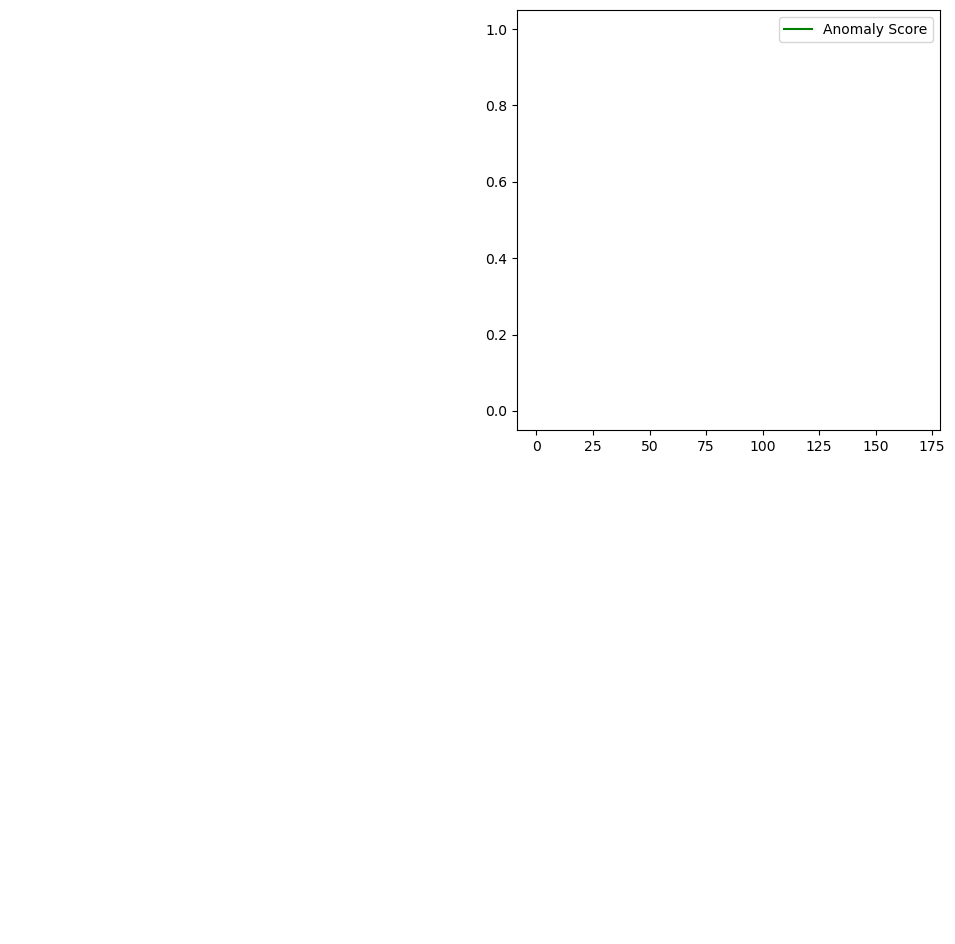

In [18]:
ani = dmad.inference(TEST_DATA_PATH, data_config, 'Test002') # returns animation of inference video

# Display the animation in the notebook.
# HTML(ani.to_jshtml())

<!-- ## 6. Weakly Supervised Video Anomaly Detection Methods -->

<!-- The weakly-supervised video anomaly detection assumes that **video-level normal/anomaly labels are given for training**. Compared to the unsupervised video anomaly detection, obtaining such video-level labels requires **more human effort** however compared to usupervised methods, weakly supervised paradigm offers several advantages:  -->

<!-- 1. Weak supervision only requires video-level annotations, where the presence of anomalous events is indicated, but their start and end locations are unknown which allows for the construction of **large-scale datasets** for anomaly detection.
2. The presence of both normal and abnormal samples and their annotation enables the model to learn more discriminative representations to **improve its performance** on large-scale datasets.

One of the most famouse large-scale dataset video anomaly detection dataset with video-level labels is **[UCF-crime dataset](https://www.crcv.ucf.edu/projects/real-world/)** that contains 1,900 untrimmed real-world outdoor and indoor surveillance videos. The total length of the videos is **128 hours**, which contains **13 classes** of anomalous events including: 1. Abuse, 2. Arrest, 3. Arson, 4. Assault, 5. Burglary, 6. Explosion, 7. Fighting, 8. Road Accident, 9. Robbery, 10. Shooting, 11. Stealing, 12. Shoplifting, 13. Vandalism. 

Although this dataset is not the main focuse of this demo, however we downloaded the dataset on the cluster and also provide the list of state-of-the-art weakly supervised video anomaly detection methods and their repositary in the below for self-exploration:

- Learning Prompt-Enhanced Context Features for Weakly-Supervised Video Anomaly Detection: https://github.com/yujiangpu20/PEL4VAD
- Unbiased Multiple Instance Learning for Weakly Supervised Video Anomaly Detection: https://github.com/ktr-hubrt/umil
- Self-Supervised Sparse Representation for Video Anomaly Detection: https://github.com/louisYen/S3R -->